# PyTorch Metric Learning
### Example for the DeepAdversarialMetricLearning trainer
See the documentation [here](https://kevinmusgrave.github.io/pytorch-metric-learning/)

## Install the necessary packages

In [ ]:
!pip install -q pytorch-metric-learning[with-hooks]
!pip install umap-learn

     |████████████████████████████████| 71kB 3.6MB/s 
     |████████████████████████████████| 35.5MB 90kB/s 
     |████████████████████████████████| 1.1MB 4.9MB/s 


## Import the packages

In [ ]:
%matplotlib inline
from pytorch_metric_learning import losses, miners, samplers, trainers, testers
from pytorch_metric_learning.utils import common_functions
import pytorch_metric_learning.utils.logging_presets as logging_presets
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
import numpy as np
import torchvision
from torchvision import datasets, transforms
import torch
import torch.nn as nn
from PIL import Image
import logging
import matplotlib.pyplot as plt
import umap
from cycler import cycler
import record_keeper
import pytorch_metric_learning
logging.getLogger().setLevel(logging.INFO)
logging.info("VERSION %s"%pytorch_metric_learning.__version__)
    

INFO:root:VERSION 0.9.84


## Simple model def

In [ ]:
class MLP(nn.Module):
    # layer_sizes[0] is the dimension of the input
    # layer_sizes[-1] is the dimension of the output
    def __init__(self, layer_sizes, final_relu=False):
        super().__init__()
        layer_list = []
        layer_sizes = [int(x) for x in layer_sizes]
        num_layers = len(layer_sizes) - 1
        final_relu_layer = num_layers if final_relu else num_layers - 1
        for i in range(len(layer_sizes) - 1):
            input_size = layer_sizes[i]
            curr_size = layer_sizes[i + 1]
            if i < final_relu_layer:
                layer_list.append(nn.ReLU(inplace=False))
            layer_list.append(nn.Linear(input_size, curr_size))
        self.net = nn.Sequential(*layer_list)
        self.last_linear = self.net[-1]

    def forward(self, x):
        return self.net(x)

## Initialize models, optimizers and image transforms

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set trunk model and replace the softmax layer with an identity function
trunk = torchvision.models.resnet18(pretrained=True)
trunk_output_size = trunk.fc.in_features
trunk.fc = common_functions.Identity()
trunk = torch.nn.DataParallel(trunk.to(device))

# Set embedder model. This takes in the output of the trunk and outputs 64 dimensional embeddings
embedder = torch.nn.DataParallel(MLP([trunk_output_size, 64]).to(device))

# Set the generator model. The input size must be 3*trunk_output_size and the output must be trunk_output_size. 
generator = torch.nn.DataParallel(MLP([3*trunk_output_size, trunk_output_size, trunk_output_size], final_relu=True))

# Set optimizers
trunk_optimizer = torch.optim.Adam(trunk.parameters(), lr=0.00001, weight_decay=0.0001)
embedder_optimizer = torch.optim.Adam(embedder.parameters(), lr=0.0001, weight_decay=0.0001)
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001, weight_decay=0.0001)

# Set the image transforms
train_transform = transforms.Compose([transforms.Resize(64),
                                    transforms.RandomResizedCrop(scale=(0.16, 1), ratio=(0.75, 1.33), size=64),
                                    transforms.RandomHorizontalFlip(0.5),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

val_transform = transforms.Compose([transforms.Resize(64),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])





Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


## Create the dataset and class-disjoint train/val splits

In [ ]:
# Download the original datasets
original_train = datasets.CIFAR100(root="CIFAR100_Dataset", train=True, transform=None, download=True)
original_val = datasets.CIFAR100(root="CIFAR100_Dataset", train=False, transform=None, download=True)

# This will be used to create train and val sets that are class-disjoint
class ClassDisjointCIFAR100(torch.utils.data.Dataset):
    def __init__(self, original_train, original_val, train, transform):
        rule = (lambda x: x < 50) if train else (lambda x: x >=50)
        train_filtered_idx = [i for i,x in enumerate(original_train.targets) if rule(x)]
        val_filtered_idx = [i for i,x in enumerate(original_val.targets) if rule(x)]
        self.data = np.concatenate([original_train.data[train_filtered_idx], original_val.data[val_filtered_idx]], axis=0)
        self.targets = np.concatenate([np.array(original_train.targets)[train_filtered_idx], np.array(original_val.targets)[val_filtered_idx]], axis=0)
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, index):            
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)
        if self.transform is not None:
            img = self.transform(img)
        return img, target

# Class disjoint training and validation set
train_dataset = ClassDisjointCIFAR100(original_train, original_val, True, train_transform)
val_dataset = ClassDisjointCIFAR100(original_train, original_val, False, val_transform)
assert set(train_dataset.targets).isdisjoint(set(val_dataset.targets))

Extracting CIFAR100_Dataset/cifar-100-python.tar.gz to CIFAR100_Dataset
Files already downloaded and verified


##Create the loss, miner, sampler, and package them into dictionaries


In [ ]:
# Set the loss function
metric_loss = losses.TripletMarginLoss(margin=0.1)
synth_loss = losses.TripletMarginLoss(margin=0.1)
g_adv_loss = losses.TripletMarginLoss(margin=0.1)

# Set the mining function
miner = miners.MultiSimilarityMiner(epsilon=0.1)

# Set the dataloader sampler
sampler = samplers.MPerClassSampler(train_dataset.targets, m=4, length_before_new_iter=len(train_dataset))

# Set other training parameters
batch_size = 32
num_epochs = 4

# Package the above stuff into dictionaries.
models = {"trunk": trunk, "embedder": embedder, "generator": generator}
optimizers = {"trunk_optimizer": trunk_optimizer, "embedder_optimizer": embedder_optimizer, "generator_optimizer": generator_optimizer}
loss_funcs = {"metric_loss": metric_loss, "synth_loss": synth_loss, "g_adv_loss": g_adv_loss}
mining_funcs = {"tuple_miner": miner}

# Each loss will be scaled by these weights.
# g_hard_loss and g_reg_loss are defined inside the trainer.
# Specifying these weights is optional.
loss_weights = {"metric_loss": 1, 
                "synth_loss": 0.1,
                "g_adv_loss": 0.1,
                "g_hard_loss": 0.1,
                "g_reg_loss": 0.1}

In [ ]:
# Remove logs if you want to train with new parameters
!rm -rf example_logs/ example_saved_models/ example_tensorboard/

## Create the training and testing hooks

In [ ]:
record_keeper, _, _ = logging_presets.get_record_keeper("example_logs", "example_tensorboard")
hooks = logging_presets.get_hook_container(record_keeper)
dataset_dict = {"val": val_dataset}
model_folder = "example_saved_models"

def visualizer_hook(umapper, umap_embeddings, labels, split_name, keyname, *args):
    logging.info("UMAP plot for the {} split and label set {}".format(split_name, keyname))
    label_set = np.unique(labels)
    num_classes = len(label_set)
    fig = plt.figure(figsize=(20,15))
    plt.gca().set_prop_cycle(cycler("color", [plt.cm.nipy_spectral(i) for i in np.linspace(0, 0.9, num_classes)]))
    for i in range(num_classes):
        idx = labels == label_set[i]
        plt.plot(umap_embeddings[idx, 0], umap_embeddings[idx, 1], ".", markersize=1)   
    plt.show()

# Create the tester
tester = testers.GlobalEmbeddingSpaceTester(end_of_testing_hook = hooks.end_of_testing_hook, 
                                            visualizer = umap.UMAP(), 
                                            visualizer_hook = visualizer_hook,
                                            dataloader_num_workers = 32,
                                            accuracy_calculator=AccuracyCalculator(k="max_bin_count"))

end_of_epoch_hook = hooks.end_of_epoch_hook(tester, 
                                            dataset_dict, 
                                            model_folder, 
                                            test_interval = 1,
                                            patience = 1)

## Create the trainer

In [ ]:
trainer = trainers.DeepAdversarialMetricLearning(models=models,
                                                optimizers=optimizers,
                                                batch_size=batch_size,
                                                loss_funcs=loss_funcs,
                                                mining_funcs=mining_funcs,
                                                dataset=train_dataset,
                                                loss_weights=loss_weights,
                                                sampler=sampler,
                                                end_of_iteration_hook=hooks.end_of_iteration_hook,
                                                end_of_epoch_hook=end_of_epoch_hook,
                                                metric_alone_epochs=1,
                                                g_alone_epochs=1,
                                                g_triplets_per_anchor=100)

# You'll see a warning like this: WARNING:root:loss_funcs is missing "classifier_loss"
# That's okay. DeepAdversarialMetricLearning allows you to add a classification network and classification loss.
# But it's not required.

## Start Tensorboard
(Turn off adblock and other shields)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir example_tensorboard

## Train the model

INFO:root:Initializing dataloader
INFO:root:Initializing dataloader iterator
INFO:root:Done creating dataloader iterator
INFO:root:TRAINING EPOCH 1
total_loss=0.11017: 100%|██████████| 937/937 [00:53<00:00, 17.45it/s]
INFO:root:Evaluating epoch 1
INFO:root:Getting embeddings for the val split
100%|██████████| 938/938 [00:14<00:00, 62.54it/s] 
INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


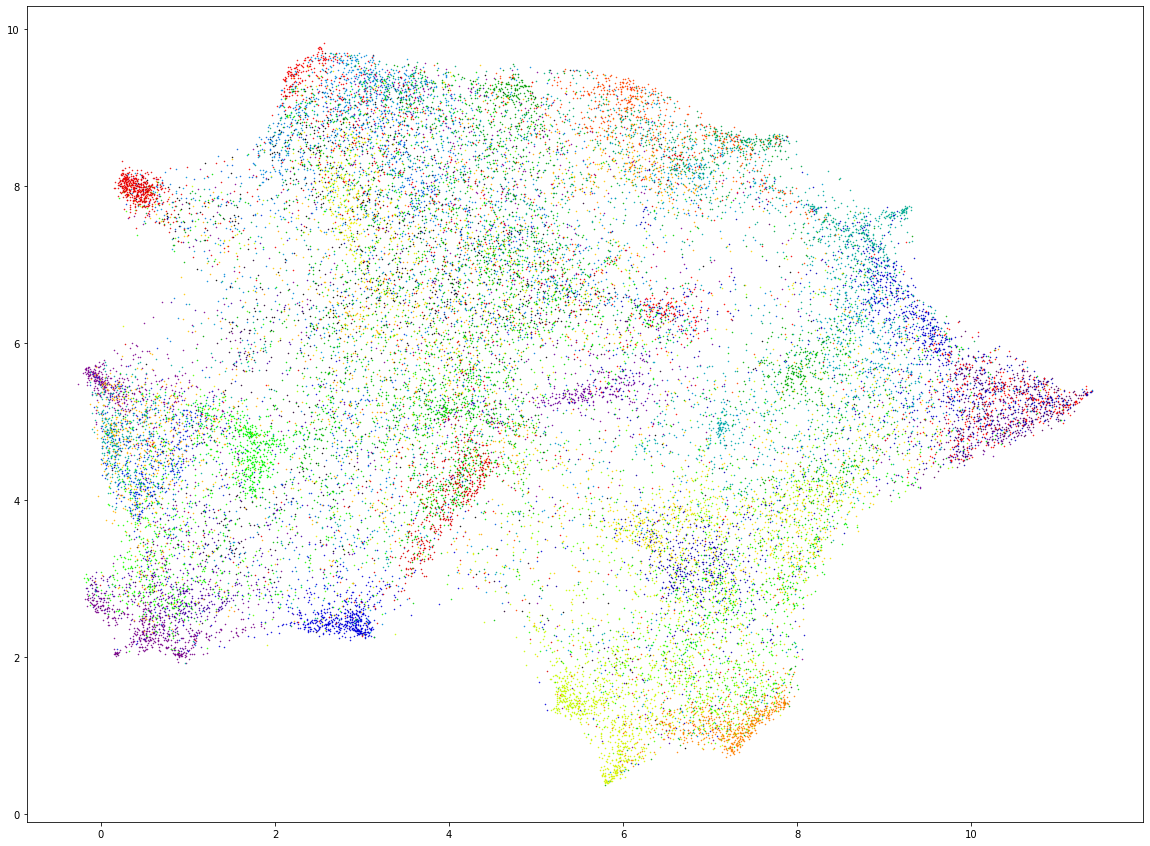

INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=600
INFO:root:embedding dimensionality is 64
INFO:root:running k-means clustering with k=50
INFO:root:embedding dimensionality is 64
INFO:root:New best accuracy!
INFO:root:TRAINING EPOCH 2
total_loss=0.00050: 100%|██████████| 937/937 [01:10<00:00, 13.32it/s]
INFO:root:Evaluating epoch 2
INFO:root:Getting embeddings for the val split
100%|██████████| 938/938 [00:15<00:00, 60.42it/s] 
INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


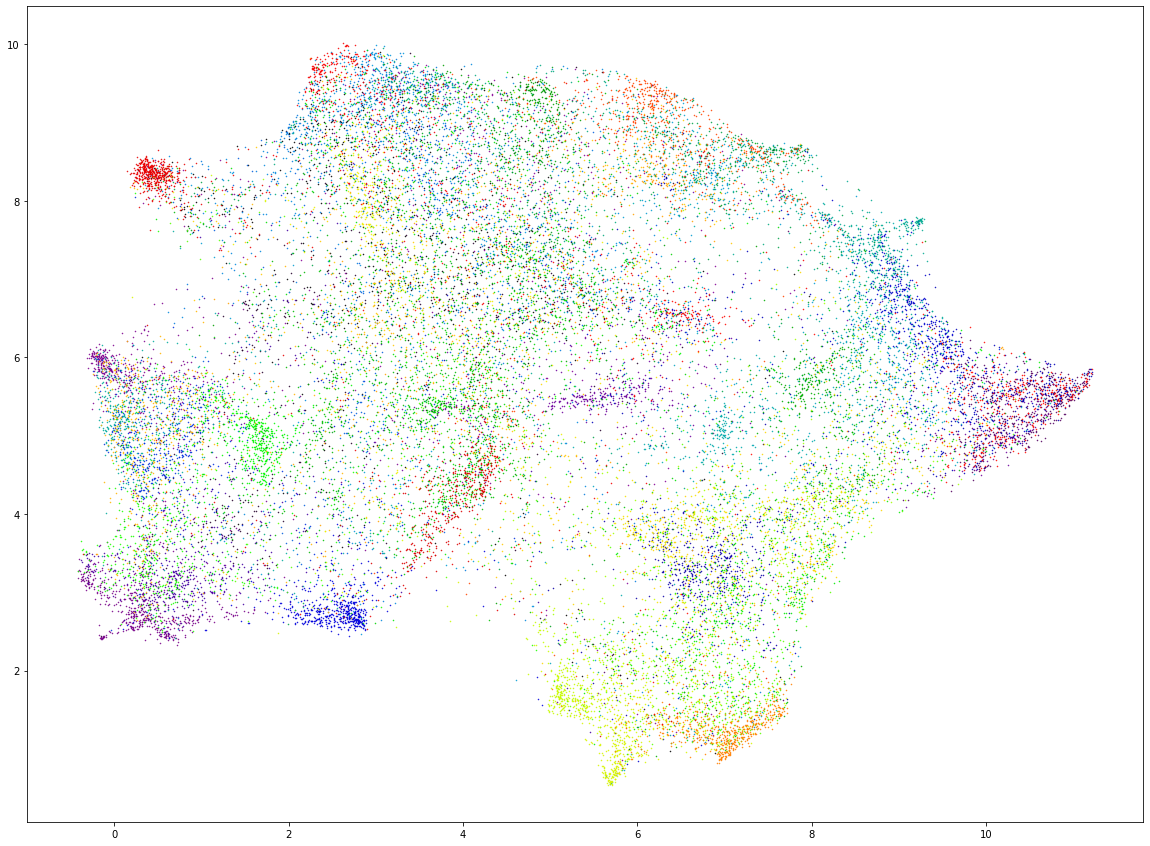

INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=600
INFO:root:embedding dimensionality is 64
INFO:root:running k-means clustering with k=50
INFO:root:embedding dimensionality is 64
INFO:root:TRAINING EPOCH 3
total_loss=0.11244: 100%|██████████| 937/937 [01:44<00:00,  8.96it/s]
INFO:root:Evaluating epoch 3
INFO:root:Getting embeddings for the val split
100%|██████████| 938/938 [00:15<00:00, 59.54it/s] 
INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


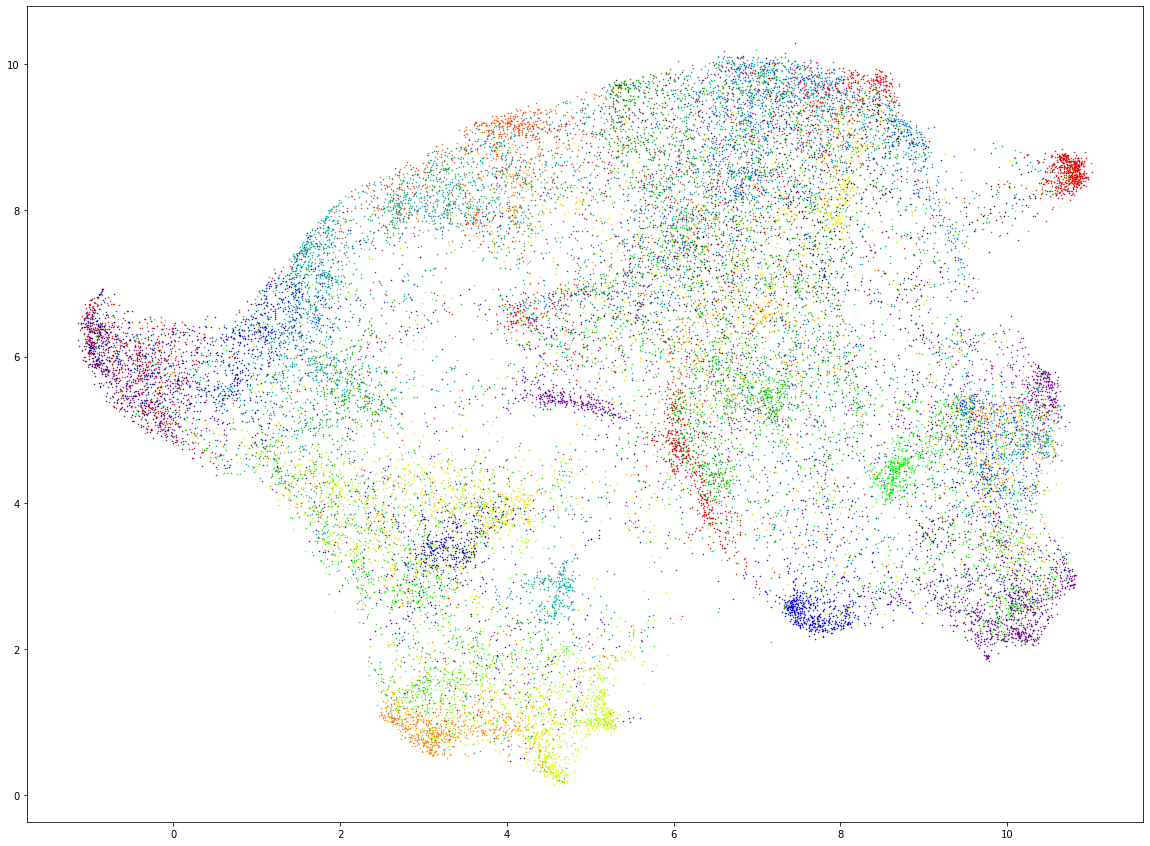

INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=600
INFO:root:embedding dimensionality is 64
INFO:root:running k-means clustering with k=50
INFO:root:embedding dimensionality is 64
INFO:root:New best accuracy!
INFO:root:TRAINING EPOCH 4
total_loss=0.11728: 100%|██████████| 937/937 [01:47<00:00,  8.71it/s]
INFO:root:Evaluating epoch 4
INFO:root:Getting embeddings for the val split
100%|██████████| 938/938 [00:15<00:00, 58.64it/s] 
INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


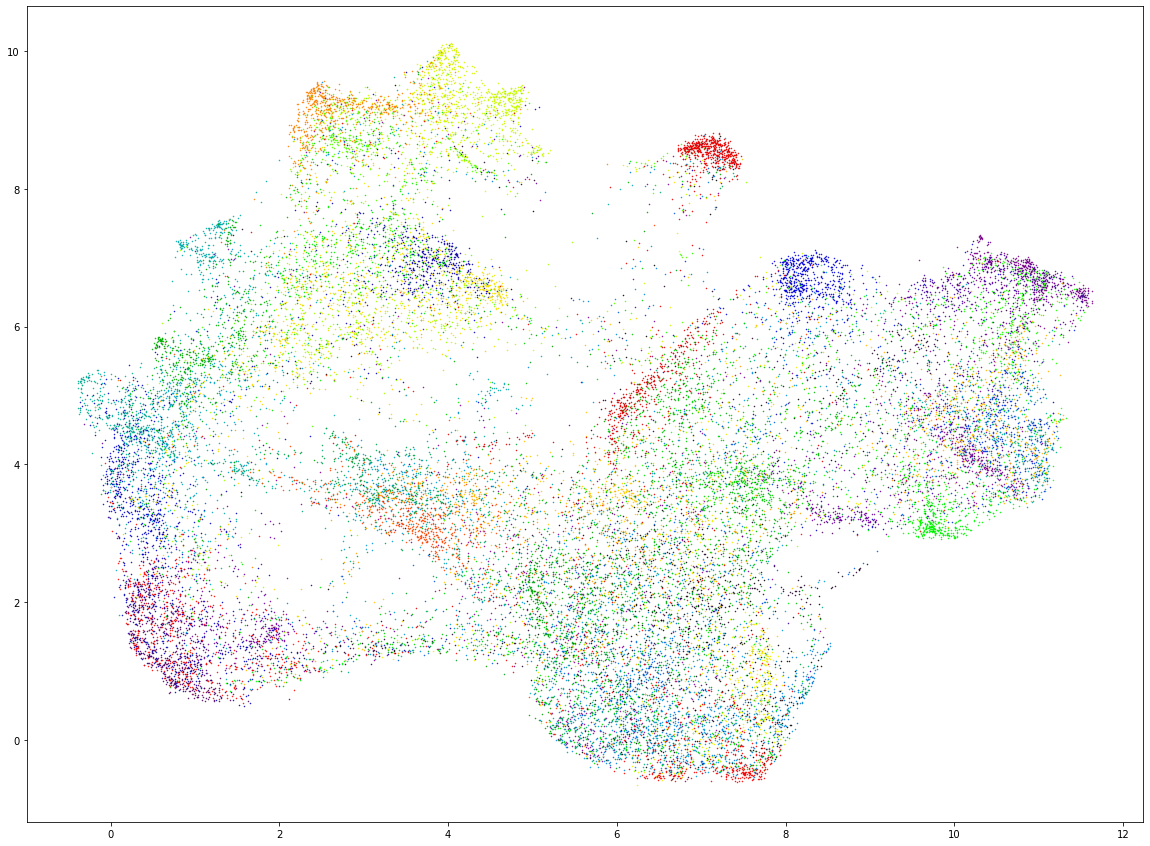

INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=600
INFO:root:embedding dimensionality is 64
INFO:root:running k-means clustering with k=50
INFO:root:embedding dimensionality is 64
INFO:root:New best accuracy!


In [ ]:
trainer.train(num_epochs=num_epochs)